In [24]:
import pandas as pd
import numpy as np
import fiona
import matplotlib.pyplot as plt
import rasterio
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling

%matplotlib inline

In [109]:
with fiona.open('data/zonal_stats/ClimateZones/censustract_selected.shp') as shapefile:
    features = [feature["geometry"] for feature in shapefile]
    ids = [feature["properties"] for feature in shapefile]
ids[0], features[0]

(OrderedDict([('tract', '6035040100'),
              ('center', 'POINT(-120.405758 40.771517)')]),
 {'coordinates': [[(-121.33192100000002, 40.913357999066086),
    (-121.33179699999965, 40.91463399906616),
    (-121.33178899999989, 40.914719999066115),
    (-121.3317879999998, 40.91473099906616),
    (-121.33178499999956, 40.91475999906613),
    (-121.33125399999967, 40.920242999066105),
    (-121.33121399999995, 40.920697999066114),
    (-121.33120800000036, 40.92076799906606),
    (-121.33118600000033, 40.92099399906606),
    (-121.33113799999995, 40.92449899906605),
    (-121.33113200000034, 40.924938999066065),
    (-121.33110700000009, 40.92672999906605),
    (-121.33110099999958, 40.92715699906605),
    (-121.33109700000016, 40.92739799906609),
    (-121.33097299999976, 40.93457199906606),
    (-121.33099000000028, 40.93841599906599),
    (-121.33099100000037, 40.938589999066046),
    (-121.33105400000018, 40.94566799906596),
    (-121.33105999999978, 40.946310999065986),
    (-

### Convert NetCDF file to multiband GeoTIFF

In [92]:
crs = 'EPSG:4326'

with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041.nc') as src:
    transform, width, height = calculate_default_transform(
        crs, crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': crs,
        'transform': transform,
        'width': width,
        'height': height,
        'driver': 'GTiff',
    })
    # Reproject to geotiff
    with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041_wgs84.tif', 'w', **kwargs) as dst:
        for i in range(1, (src.count + 1)):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=src.crs,
                resampling=Resampling.nearest)

### Clip GeoTIFF file with polygon

In [103]:
with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041_wgs84.tif') as src:
    # Clip
    out_image, out_transform = rasterio.mask.mask(src, [features[1]], crop=True)
    out_meta = src.meta.copy()
    out_meta.update({'driver': 'GTiff',
                 'height': out_image.shape[1],
                 'width': out_image.shape[2],
                 'transform': out_transform})
    with rasterio.open('data/zonal_stats/censustract_wgs84.tif', 'w', **out_meta) as dest:
        dest.write(out_image)

261.8005 269.71347 267.0435763888889


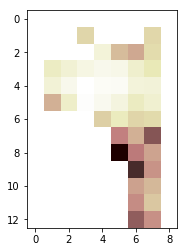

In [105]:
with rasterio.open('data/zonal_stats/censustract_wgs84.tif') as src:
    arr = src.read(1, masked=True)
    print(arr.min(), arr.max(), arr.mean())
    plt.imshow(arr, cmap='pink')
    plt.show()  

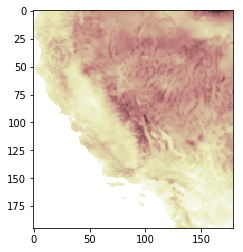

In [103]:
with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041.nc') as src:
    arr = src.read(1, masked=True)
    plt.imshow(arr, cmap='pink')
    plt.show()  

In [106]:
with rasterio.open('data/zonal_stats/tasmin_HadGEM2-ES_2041_wgs84.tif') as src:
    nodata = src.nodata
    date = np.array('2041-01-01', dtype=np.datetime64)
    date_arr = date + np.arange(365)
    mean_arr = []
    
    out_image, out_transform = rasterio.mask.mask(src, [features[1]], crop=True)
    bands = len(out_image)

    for i in range(0, bands):
        vals = out_image[i]
        data = vals[vals != nodata]
        mean_arr.append(data.mean())
        
    df = pd.DataFrame({'date':date_arr, 'value':mean_arr})
    print(df)

          date       value
0   2041-01-01  267.043579
1   2041-01-02  272.191284
2   2041-01-03  265.844177
3   2041-01-04  260.013245
4   2041-01-05  262.420410
5   2041-01-06  259.982361
6   2041-01-07  261.081665
7   2041-01-08  262.618774
8   2041-01-09  267.744995
9   2041-01-10  266.437775
10  2041-01-11  267.332733
11  2041-01-12  268.314972
12  2041-01-13  269.223877
13  2041-01-14  271.822418
14  2041-01-15  268.617615
15  2041-01-16  269.081726
16  2041-01-17  268.949219
17  2041-01-18  274.532318
18  2041-01-19  271.514160
19  2041-01-20  267.100494
20  2041-01-21  269.596375
21  2041-01-22  266.568298
22  2041-01-23  266.969452
23  2041-01-24  267.932953
24  2041-01-25  267.406067
25  2041-01-26  267.847992
26  2041-01-27  273.056213
27  2041-01-28  276.853943
28  2041-01-29  269.239685
29  2041-01-30  265.311340
..         ...         ...
335 2041-12-02  273.088196
336 2041-12-03  268.997131
337 2041-12-04  266.219421
338 2041-12-05  263.335663
339 2041-12-06  267.763275
3